OPENING KEYNOTE Code Europe 2023 Tech Festival - "Idiomatic Pandas" by Matt Harrison (MetaSnake)
https://www.youtube.com/watch?v=CDcSq5wzFTo&t=846s

In [1]:
import numpy as np
import pandas as pd
import pyarrow as pa

- Load Data
- Types
- Chainig
- Mutation
- Apply
- Aggregation

## 1. IMPORTACION DE DATOS
Utilizaremos con Pandas 2, el motor de pyarrow.

In [2]:
autos = pd.read_csv('vehicles.csv', dtype_backend='pyarrow', engine='pyarrow')

Utilaremos una funcion creada por Matt para limpieza de datos. Tweak (retocado)

In [3]:
# a glorious function
def tweak_autos(autos):
    cols = ['city08', 'comb08', 'highway08', 'cylinders', 'displ', 'drive', 'eng_dscr', 
        'fuelCost08', 'make', 'model', 'trany', 'range', 'createdOn', 'year']
    return (autos
     [cols]
     .assign(cylinders=autos.cylinders.fillna(0).astype('int8[pyarrow]'),
             displ=autos.displ.fillna(0).astype('float32[pyarrow]'),
             drive=autos.drive.replace('', 'Other').astype('category'),
             automatic=autos.trany.astype(str).str.contains('Auto'),
             speeds=autos.trany.astype(str).str.extract(r'(\d+)').fillna('20').astype('int8[pyarrow]'),
             createdOn=pd.to_datetime(autos
                .createdOn
                .replace({' EDT': ' -0400', ' EST': ' -0500'}, regex=True),
                          format='%a %b %d %H:%M:%S %z %Y', utc=True)
                .dt.tz_convert('America/New_York'),
             ffs=autos.eng_dscr.str.contains('FFS')
            )
     .astype({'highway08': 'int8[pyarrow]', 'city08': 'int16[pyarrow]', 'comb08': 'int16[pyarrow]', 'fuelCost08': 'int16[pyarrow]',
              'range': 'int16[pyarrow]',  'year': 'int16[pyarrow]', 'make': 'category'})
     .loc[:, ['city08', 'comb08', 'highway08', 'cylinders', 'displ', 'drive',
       'fuelCost08', 'make', 'model', 'range', 'createdOn', 'year',
       'automatic', 'speeds', 'ffs']]
    )

tweak_autos(autos).head(5)

,city08,comb08,highway08,cylinders,displ,drive,fuelCost08,make,model,range,createdOn,year,automatic,speeds,ffs
0,19,21,25,4,2.0,Rear-Wheel Drive,2000,Alfa Romeo,Spider Veloce 2000,0,2013-01-01 00:00:00-05:00,1985,False,5,True
1,9,11,14,12,4.9,Rear-Wheel Drive,3850,Ferrari,Testarossa,0,2013-01-01 00:00:00-05:00,1985,False,5,False
2,23,27,33,4,2.2,Front-Wheel Drive,1550,Dodge,Charger,0,2013-01-01 00:00:00-05:00,1985,False,5,True
3,10,11,12,8,5.2,Rear-Wheel Drive,3850,Dodge,B150/B250 Wagon 2WD,0,2013-01-01 00:00:00-05:00,1985,True,3,<NA>
4,17,19,23,4,2.2,4-Wheel or All-Wheel Drive,2700,Subaru,Legacy AWD Turbo,0,2013-01-01 00:00:00-05:00,1993,False,5,True


Volvemos con la BD inicial:

In [4]:
autos.head()

,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,...,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb
0,15.695714,0.0,0.0,0.0,19,0.0,0,0.0,0.0,0.0,...,<NA>,<NA>,0.0,<NA>,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,<NA>,0,0,0
1,29.964545,0.0,0.0,0.0,9,0.0,0,0.0,0.0,0.0,...,<NA>,<NA>,0.0,<NA>,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,<NA>,0,0,0
2,12.207778,0.0,0.0,0.0,23,0.0,0,0.0,0.0,0.0,...,<NA>,<NA>,0.0,<NA>,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,<NA>,0,0,0
3,29.964545,0.0,0.0,0.0,10,0.0,0,0.0,0.0,0.0,...,<NA>,<NA>,0.0,<NA>,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,<NA>,0,0,0
4,17.347895,0.0,0.0,0.0,17,0.0,0,0.0,0.0,0.0,...,<NA>,<NA>,0.0,<NA>,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,<NA>,0,0,0


In [5]:
# Un vistazo del dataframe .info(). Veremos que como son muchas columnas, no es facil verlos
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41144 entries, 0 to 41143
Data columns (total 83 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   barrels08        41144 non-null  double[pyarrow]
 1   barrelsA08       41144 non-null  double[pyarrow]
 2   charge120        41144 non-null  double[pyarrow]
 3   charge240        41144 non-null  double[pyarrow]
 4   city08           41144 non-null  int64[pyarrow] 
 5   city08U          41144 non-null  double[pyarrow]
 6   cityA08          41144 non-null  int64[pyarrow] 
 7   cityA08U         41144 non-null  double[pyarrow]
 8   cityCD           41144 non-null  double[pyarrow]
 9   cityE            41144 non-null  double[pyarrow]
 10  cityUF           41144 non-null  double[pyarrow]
 11  co2              41144 non-null  int64[pyarrow] 
 12  co2A             41144 non-null  int64[pyarrow] 
 13  co2TailpipeAGpm  41144 non-null  double[pyarrow]
 14  co2TailpipeGpm   41144

In [6]:
# vemos los nombres de la columnas
autos.columns

Index(['barrels08', 'barrelsA08', 'charge120', 'charge240', 'city08',
       'city08U', 'cityA08', 'cityA08U', 'cityCD', 'cityE', 'cityUF', 'co2',
       'co2A', 'co2TailpipeAGpm', 'co2TailpipeGpm', 'comb08', 'comb08U',
       'combA08', 'combA08U', 'combE', 'combinedCD', 'combinedUF', 'cylinders',
       'displ', 'drive', 'engId', 'eng_dscr', 'feScore', 'fuelCost08',
       'fuelCostA08', 'fuelType', 'fuelType1', 'ghgScore', 'ghgScoreA',
       'highway08', 'highway08U', 'highwayA08', 'highwayA08U', 'highwayCD',
       'highwayE', 'highwayUF', 'hlv', 'hpv', 'id', 'lv2', 'lv4', 'make',
       'model', 'mpgData', 'phevBlended', 'pv2', 'pv4', 'range', 'rangeCity',
       'rangeCityA', 'rangeHwy', 'rangeHwyA', 'trany', 'UCity', 'UCityA',
       'UHighway', 'UHighwayA', 'VClass', 'year', 'youSaveSpend', 'guzzler',
       'trans_dscr', 'tCharger', 'sCharger', 'atvType', 'fuelType2', 'rangeA',
       'evMotor', 'mfrCode', 'c240Dscr', 'charge240b', 'c240bDscr',
       'createdOn', 'modifiedOn

In [7]:
# Veremos la memoria utilizada en Pandas 2.x (suma de columnas).
autos.memory_usage(deep=False).sum()

29727105

In [8]:
# Viendo la cantidad de funcionalidades que tiene Pandas para este dataframe..Veremos 521 funcionalidades!
print(len(dir(autos)))

521


## 2. TYPES DE DATOS
Trabajar con los "Types" correctos de datos hara que tengamos un analisis correcto.

Asimismo, debemos seleccionar y trabajar solo con las columnas relevantes para nuestro analisis

In [9]:
# Creo un OBJETO con la Lista de columnas SOLO relevantes.
cols=['city08','comb08','highway08','cylinders','displ', 'drive','eng_dscr','fuelCost08','make','model','trany',
      'range','createdOn','year']

In [10]:
# Verifico los Types. <df[lista_de_cols].dtypes>
autos[cols].dtypes

city08         int64[pyarrow]
comb08         int64[pyarrow]
highway08      int64[pyarrow]
cylinders      int64[pyarrow]
displ         double[pyarrow]
drive         string[pyarrow]
eng_dscr      string[pyarrow]
fuelCost08     int64[pyarrow]
make          string[pyarrow]
model         string[pyarrow]
trany         string[pyarrow]
range          int64[pyarrow]
createdOn     string[pyarrow]
year           int64[pyarrow]
dtype: object

In [11]:
#Vemos la memoria que ocupa cada columna y la suma. Aqui se demuestra que en Pandas 2 se optimiza mejor optimizado con pyarrow.
autos[cols].memory_usage(deep=False)

Index             132
city08         329152
comb08         329152
highway08      329152
cylinders      331949
displ          331949
drive          879028
eng_dscr       364037
fuelCost08     329152
make           425635
model          632502
trany          754183
range          329152
createdOn     1316608
year           329152
dtype: int64

In [12]:
# En pandas 2 utilizando pyarrow con baced se ocupa la tercera parte de la memoria
autos[cols].memory_usage(deep=False).sum()

7010935

Valores Enteros (Integer). 
No soporta Mising Values

In [13]:
#Utilizando el metodo describe para valores int, con select_dtypes()
autos[cols].select_dtypes(int).describe()


,city08,comb08,highway08,cylinders,fuelCost08,range,year
count,41144.000000,41144.000000,41144.000000,40938.000000,41144.000000,41144.000000,41144.000000
mean,18.369045,20.616396,24.504667,5.717084,2362.335942,0.793506,2001.535266
std,7.905886,7.674535,7.730364,1.755517,654.981925,13.041592,11.142414
min,6.000000,7.000000,9.000000,2.000000,500.000000,0.000000,1984.000000
25%,15.000000,17.000000,20.000000,4.000000,1900.000000,0.000000,1991.000000
50%,17.000000,20.000000,24.000000,6.000000,2350.000000,0.000000,2002.000000
75%,20.000000,23.000000,28.000000,6.000000,2700.000000,0.000000,2011.000000
max,150.000000,136.000000,124.000000,16.000000,7400.000000,370.000000,2020.000000


## 3. CHAINING (Desacoplando)
Desaclopamiento de las operaciones de las expresiones. Se desacopla el código


In [14]:
#El codigo de arriba se puede encadenar y ver poco a poco. Nos permitira ver paso a paso los resultados
# El ( se utiliza para escapar del indentado del python

(autos
 [cols]
 .select_dtypes(int)
 .describe()
 )

,city08,comb08,highway08,cylinders,fuelCost08,range,year
count,41144.000000,41144.000000,41144.000000,40938.000000,41144.000000,41144.000000,41144.000000
mean,18.369045,20.616396,24.504667,5.717084,2362.335942,0.793506,2001.535266
std,7.905886,7.674535,7.730364,1.755517,654.981925,13.041592,11.142414
min,6.000000,7.000000,9.000000,2.000000,500.000000,0.000000,1984.000000
25%,15.000000,17.000000,20.000000,4.000000,1900.000000,0.000000,1991.000000
50%,17.000000,20.000000,24.000000,6.000000,2350.000000,0.000000,2002.000000
75%,20.000000,23.000000,28.000000,6.000000,2700.000000,0.000000,2011.000000
max,150.000000,136.000000,124.000000,16.000000,7400.000000,370.000000,2020.000000


chaining y modificar los tipos de datos: int8, int16, uint8 [pyarrow]


In [15]:
# puede comb08 ser  int8?. Le preguntaremos a numpy lo q soporta int8...R: valores de -128 a 127. So, no.
np.iinfo(np.int8)



iinfo(min=-128, max=127, dtype=int8)

In [16]:
#vimos que comb08 no puede ser int8, pero uint8 si podra
np.iinfo(np.uint8)

iinfo(min=0, max=255, dtype=uint8)

In [17]:
#Hacemos los cambio de datos (utilizaremos los chaining):
# funcion astype con un diccionario mapeando las columnas con el tipo de datos
(autos
 [cols]
 .astype({'highway08':'int8[pyarrow]', 'city08':'int16[pyarrow]', 'comb08':'uint8[pyarrow]'})
 .select_dtypes(['integer']) #Slecciona enteros
 .describe()
)

,city08,comb08,highway08,cylinders,fuelCost08,range,year
count,41144.000000,41144.000000,41144.000000,40938.000000,41144.000000,41144.000000,41144.000000
mean,18.369045,20.616396,24.504667,5.717084,2362.335942,0.793506,2001.535266
std,7.905886,7.674535,7.730364,1.755517,654.981925,13.041592,11.142414
min,6.000000,7.000000,9.000000,2.000000,500.000000,0.000000,1984.000000
25%,15.000000,17.000000,20.000000,4.000000,1900.000000,0.000000,1991.000000
50%,17.000000,20.000000,24.000000,6.000000,2350.000000,0.000000,2002.000000
75%,20.000000,23.000000,28.000000,6.000000,2700.000000,0.000000,2011.000000
max,150.000000,136.000000,124.000000,16.000000,7400.000000,370.000000,2020.000000


In [18]:
(autos
 [cols]
 .astype({'highway08':'int8[pyarrow]', 'city08':'int16[pyarrow]', 'comb08':'uint8[pyarrow]'})
 .memory_usage()
 .sum()
)

6203484

<Axes: >

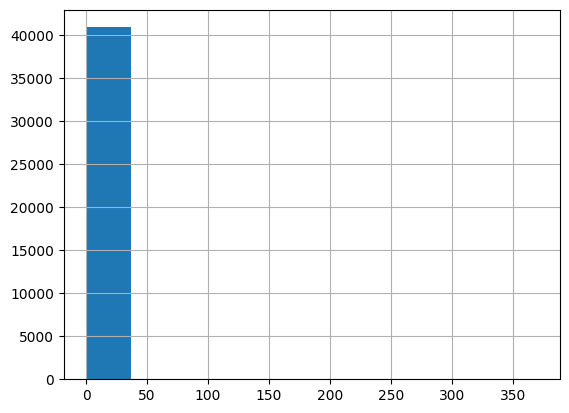

In [19]:
#Graficaremos por ejm range
autos.range.hist()

<Axes: >

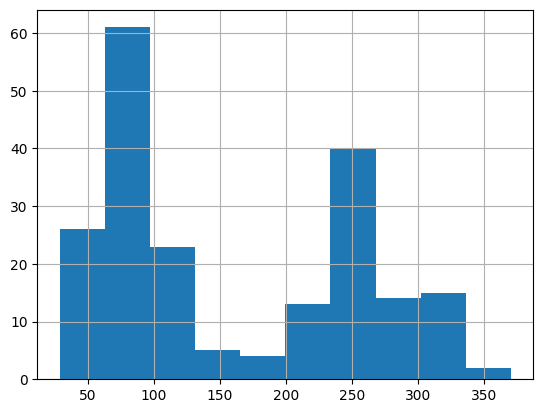

In [20]:
#Seleccionando los range > 20
(autos
 .query('range>20')
 .range.hist()
 )

In [21]:
#FANCY QUERY
( autos
 [cols]
 .describe()
 )

,city08,comb08,highway08,cylinders,displ,fuelCost08,range,year
count,41144.000000,41144.000000,41144.000000,40938.000000,40940.000000,41144.000000,41144.000000,41144.000000
mean,18.369045,20.616396,24.504667,5.717084,3.294238,2362.335942,0.793506,2001.535266
std,7.905886,7.674535,7.730364,1.755517,1.357151,654.981925,13.041592,11.142414
min,6.000000,7.000000,9.000000,2.000000,0.000000,500.000000,0.000000,1984.000000
25%,15.000000,17.000000,20.000000,4.000000,2.200000,1900.000000,0.000000,1991.000000
50%,17.000000,20.000000,24.000000,6.000000,3.000000,2350.000000,0.000000,2002.000000
75%,20.000000,23.000000,28.000000,6.000000,4.300000,2700.000000,0.000000,2011.000000
max,150.000000,136.000000,124.000000,16.000000,8.400000,7400.000000,370.000000,2020.000000


In [22]:
#FANCY QUERY
( autos
 [cols]
 .describe()
 .loc[:, lambda a_df: a_df.loc["max"]<=255]
 )

,city08,comb08,highway08,cylinders,displ
count,41144.000000,41144.000000,41144.000000,40938.000000,40940.000000
mean,18.369045,20.616396,24.504667,5.717084,3.294238
std,7.905886,7.674535,7.730364,1.755517,1.357151
min,6.000000,7.000000,9.000000,2.000000,0.000000
25%,15.000000,17.000000,20.000000,4.000000,2.200000
50%,17.000000,20.000000,24.000000,6.000000,3.000000
75%,20.000000,23.000000,28.000000,6.000000,4.300000
max,150.000000,136.000000,124.000000,16.000000,8.400000


Chaining.
Seleccion de Columnas

In [23]:
(autos
 [cols]
 .astype({'highway08':'int8[pyarrow]', 'city08':'int16[pyarrow]', 'comb08':'int16[pyarrow]', 'fuelCost08':'int16[pyarrow]',
          'range':'int16[pyarrow]', 'year':'int16[pyarrow]'})
 .select_dtypes(['integer']) #Selecciona enteros
 .describe()
)

,city08,comb08,highway08,cylinders,fuelCost08,range,year
count,41144.000000,41144.000000,41144.000000,40938.000000,41144.000000,41144.000000,41144.000000
mean,18.369045,20.616396,24.504667,5.717084,2362.335942,0.793506,2001.535266
std,7.905886,7.674535,7.730364,1.755517,654.981925,13.041592,11.142414
min,6.000000,7.000000,9.000000,2.000000,500.000000,0.000000,1984.000000
25%,15.000000,17.000000,20.000000,4.000000,1900.000000,0.000000,1991.000000
50%,17.000000,20.000000,24.000000,6.000000,2350.000000,0.000000,2002.000000
75%,20.000000,23.000000,28.000000,6.000000,2700.000000,0.000000,2011.000000
max,150.000000,136.000000,124.000000,16.000000,7400.000000,370.000000,2020.000000


In [24]:
(autos
 [cols]
 .astype({'highway08':'int8[pyarrow]', 'city08':'int16[pyarrow]', 
          'comb08':'int16[pyarrow]', 'fuelCost08':'int16[pyarrow]',
          'range':'int16[pyarrow]', 'year':'int16[pyarrow]'})
 .select_dtypes(['integer']) #Selecciona enteros
 .memory_usage(deep=True)
 .sum()
)

815523

Chaining.
Seleccion de Columnas float (decimales)

In [25]:
(
    autos
    [cols]
    .select_dtypes(['float'])
)

,displ
0,2.0
1,4.9
2,2.2
3,5.2
4,2.2
...,...
41139,2.2
41140,2.2
41141,2.2
41142,2.2


In [26]:
#In pandas 2.0 'cylinders' aparecera como int, pero en 1.0 como float (debido a los valores NA)
print ("1. Tipo de dato ===>", autos.cylinders.dtype)
print ("2. Describe ===>", autos.cylinders.describe())
print ("3. NAs ===>", autos.cylinders.isna().sum())

1. Tipo de dato ===> int64[pyarrow]
2. Describe ===> count    40938.000000
mean         5.717084
std          1.755517
min          2.000000
25%          4.000000
50%          6.000000
75%          6.000000
max         16.000000
Name: cylinders, dtype: double[pyarrow]
3. NAs ===> 206


Chaining: Actualizando columnas

metodo .assign

In [27]:
(
autos
[cols]
.assign(cylinders=autos.cylinders.fillna(0).astype('int8[pyarrow]'),
        displ=autos.displ.fillna(0))
.astype({'highway08':'int8[pyarrow]', 'city08':'int16[pyarrow]', 'comb08':'int16[pyarrow]',
         'fuelCost08':'int16[pyarrow]', 'range':'int16[pyarrow]', 'year':'int16[pyarrow]'})
.describe()
)

,city08,comb08,highway08,cylinders,displ,fuelCost08,range,year
count,41144.000000,41144.000000,41144.000000,41144.000000,41144.000000,41144.000000,41144.000000,41144.000000
mean,18.369045,20.616396,24.504667,5.688460,3.277904,2362.335942,0.793506,2001.535266
std,7.905886,7.674535,7.730364,1.797009,1.373415,654.981925,13.041592,11.142414
min,6.000000,7.000000,9.000000,0.000000,0.000000,500.000000,0.000000,1984.000000
25%,15.000000,17.000000,20.000000,4.000000,2.200000,1900.000000,0.000000,1991.000000
50%,17.000000,20.000000,24.000000,6.000000,3.000000,2350.000000,0.000000,2002.000000
75%,20.000000,23.000000,28.000000,6.000000,4.300000,2700.000000,0.000000,2011.000000
max,150.000000,136.000000,124.000000,16.000000,8.400000,7400.000000,370.000000,2020.000000


Chaining.

Seleccion de Columnas strings (Object to string)

In [28]:
(
    autos
    [cols]
    .select_dtypes(['string'])
)

,drive,eng_dscr,make,model,trany,createdOn
0,Rear-Wheel Drive,(FFS),Alfa Romeo,Spider Veloce 2000,Manual 5-spd,Tue Jan 01 00:00:00 EST 2013
1,Rear-Wheel Drive,(GUZZLER),Ferrari,Testarossa,Manual 5-spd,Tue Jan 01 00:00:00 EST 2013
2,Front-Wheel Drive,(FFS),Dodge,Charger,Manual 5-spd,Tue Jan 01 00:00:00 EST 2013
3,Rear-Wheel Drive,<NA>,Dodge,B150/B250 Wagon 2WD,Automatic 3-spd,Tue Jan 01 00:00:00 EST 2013
4,4-Wheel or All-Wheel Drive,"(FFS,TRBO)",Subaru,Legacy AWD Turbo,Manual 5-spd,Tue Jan 01 00:00:00 EST 2013
...,...,...,...,...,...,...
41139,Front-Wheel Drive,(FFS),Subaru,Legacy,Automatic 4-spd,Tue Jan 01 00:00:00 EST 2013
41140,Front-Wheel Drive,(FFS),Subaru,Legacy,Manual 5-spd,Tue Jan 01 00:00:00 EST 2013
41141,4-Wheel or All-Wheel Drive,(FFS),Subaru,Legacy AWD,Automatic 4-spd,Tue Jan 01 00:00:00 EST 2013
41142,4-Wheel or All-Wheel Drive,(FFS),Subaru,Legacy AWD,Manual 5-spd,Tue Jan 01 00:00:00 EST 2013


Arriba vimos que hay diferentes tipos de datos string. Hay datos similares a categoricos (pocos valores), datos con diferentes caracteres y datos tipo fecha. Estos datos fecha Pandas 2.x lo reconocerá como string

In [29]:
# Veremos la cantidad de NAs
(
    autos
    [cols]
    .select_dtypes(['string'])
    .isna().sum()
)

drive         1189
eng_dscr     16153
make             0
model            0
trany           11
createdOn        0
dtype: int64

In [30]:
# Veremos la cantidad de datos en columna drive 
(autos.drive.value_counts(dropna=False)) #dropna=False para que se note los NAs

drive
Front-Wheel Drive             14236
Rear-Wheel Drive              13831
4-Wheel or All-Wheel Drive     6648
All-Wheel Drive                3015
4-Wheel Drive                  1460
<NA>                           1189
2-Wheel Drive                   507
Part-time 4-Wheel Drive         258
Name: count, dtype: int64[pyarrow]

In [31]:
# Buscaremos a que se deben esos <NA>
(
    autos
    [cols]
    .query('drive.isna()')
    .head(5)
)

,city08,comb08,highway08,cylinders,displ,drive,eng_dscr,fuelCost08,make,model,trany,range,createdOn,year
7138,81,85,91,<NA>,<NA>,<NA>,<NA>,800,Nissan,Altra EV,<NA>,90,Tue Jan 01 00:00:00 EST 2013,2000
8144,74,65,58,<NA>,<NA>,<NA>,<NA>,1000,Ford,Th!nk,<NA>,29,Tue Jan 01 00:00:00 EST 2013,2001
8147,84,75,66,<NA>,<NA>,<NA>,<NA>,900,Nissan,Hyper-Mini,<NA>,33,Tue Jan 01 00:00:00 EST 2013,2001
18217,18,21,25,4,2.0,<NA>,(FFS),2000,Alfa Romeo,Spider Veloce 2000,Manual 5-spd,0,Tue Jan 01 00:00:00 EST 2013,1984
18218,20,22,26,4,1.5,<NA>,(FFS),1900,Bertone,X1/9,Manual 5-spd,0,Tue Jan 01 00:00:00 EST 2013,1984


In [32]:
(
    autos
    [cols]
    .query('drive ==""')
)

,city08,comb08,highway08,cylinders,displ,drive,eng_dscr,fuelCost08,make,model,trany,range,createdOn,year


Chaining.

Seleccion de Columnas a CATEGORICOS 

In [33]:
(
autos
[cols]
.assign(cylinders=autos.cylinders.fillna(0).astype('int8[pyarrow]'),
        displ=autos.displ.fillna(0),
        drive=autos.drive.replace('','OTROS').astype('category')
        )
.astype({'highway08':'int8[pyarrow]', 'city08':'int16[pyarrow]', 'comb08':'int16[pyarrow]',
         'fuelCost08':'int16[pyarrow]', 'range':'int16[pyarrow]', 'year':'int16[pyarrow]',
         'make':'category'})
.iloc[7138]
)

city08                                  81
comb08                                  85
highway08                               91
cylinders                                0
displ                                  0.0
drive                                  NaN
eng_dscr                              <NA>
fuelCost08                             800
make                                Nissan
model                             Altra EV
trany                                 <NA>
range                                   90
createdOn     Tue Jan 01 00:00:00 EST 2013
year                                  2000
Name: 7138, dtype: object

In [34]:
(
autos
[cols]
.assign(cylinders=autos.cylinders.fillna(0).astype('int8[pyarrow]'),
        displ=autos.displ.fillna(0).astype('float32[pyarrow]'),
        drive=autos.drive.replace('','OTROS').astype('category'))
.astype({'highway08':'int8[pyarrow]', 'city08':'int16[pyarrow]', 'comb08':'int16[pyarrow]',
         'fuelCost08':'int16[pyarrow]', 'range':'int16[pyarrow]', 'year':'int16[pyarrow]',
         'make':'category'})
.memory_usage(deep=True)
.sum()
)

3897075

In [35]:
#Inspeccionaremos la columna trany
#Parece que hay 2 piezas de datos: Automatico y manual, pero tambien speeds
(
    autos
    .trany
    .value_counts(dropna=False)
)

trany
Automatic 4-spd                     11047
Manual 5-spd                         8361
Automatic 3-spd                      3151
Automatic (S6)                       3106
Manual 6-spd                         2757
Automatic 5-spd                      2203
Automatic (S8)                       1665
Automatic 6-spd                      1619
Manual 4-spd                         1483
Automatic (S5)                        833
Automatic (variable gear ratios)      826
Automatic 7-spd                       724
Automatic 8-spd                       433
Automatic (AM-S7)                     424
Automatic (S7)                        327
Automatic 9-spd                       293
Automatic (AM7)                       245
Automatic (S4)                        233
Automatic (AV-S6)                     208
Automatic (A1)                        201
Automatic (AM6)                       151
Automatic (AV-S7)                     139
Automatic (S10)                       124
Automatic (AM-S6)           

In [36]:
# Intentemos añadir automatico y velocidades, luego borrar trany
# Veremos q Pandas 2 no 
(
autos
[cols]
.assign(cylinders=autos.cylinders.fillna(0).astype('int8[pyarrow]'),
        displ=autos.displ.fillna(0).astype('float32[pyarrow]'),
        drive=autos.drive.replace('','OTROS').astype('category'),
        automatic=autos.trany.str.contains('Auto'),
        #Pyarrow no le gusta el siguiente codigo
        speeds=autos.trany.str.extract(r'(\d+)').fillna('20').astype('int[pyarrow]')
        )
.astype({'highway08':'int8[pyarrow]', 'city08':'int16[pyarrow]', 'comb08':'int16[pyarrow]',
         'fuelCost08':'int16[pyarrow]', 'range':'int16[pyarrow]', 'year':'int16[pyarrow]',
         'make':'category'})
.drop(columns=['trany'])
)

NotImplementedError: str.extract not supported with pd.ArrowDtype(pa.string()).

In [ ]:
# str.extract no esta soportado por pyarrow 
# entonces lo usare como Pandas 1.x

(
autos
[cols]
.assign(cylinders=autos.cylinders.fillna(0).astype('int8[pyarrow]'),
        displ=autos.displ.fillna(0).astype('float32[pyarrow]'),
        drive=autos.drive.replace('','OTROS').astype('category'),
        automatic=autos.trany.str.contains('Auto'),
        #Pyarrow no le gusta el siguiente codigo
        #speeds=autos.trany.str.extract(r'(\d+)').fillna('20').astype('int[pyarrow]')
        speeds=autos.trany.astype(str).str.extract(r'(\d+)').fillna('20').astype('int8[pyarrow]')
        )
.astype({'highway08':'int8[pyarrow]', 'city08':'int16[pyarrow]', 'comb08':'int16[pyarrow]',
         'fuelCost08':'int16[pyarrow]', 'range':'int16[pyarrow]', 'year':'int16[pyarrow]',
         'make':'category'})
.drop(columns=['trany'])
.head(5)
)

,city08,comb08,highway08,cylinders,displ,drive,eng_dscr,fuelCost08,make,model,range,createdOn,year,automatic,speeds
0,19,21,25,4,2.0,Rear-Wheel Drive,(FFS),2000,Alfa Romeo,Spider Veloce 2000,0,Tue Jan 01 00:00:00 EST 2013,1985,False,5
1,9,11,14,12,4.9,Rear-Wheel Drive,(GUZZLER),3850,Ferrari,Testarossa,0,Tue Jan 01 00:00:00 EST 2013,1985,False,5
2,23,27,33,4,2.2,Front-Wheel Drive,(FFS),1550,Dodge,Charger,0,Tue Jan 01 00:00:00 EST 2013,1985,False,5
3,10,11,12,8,5.2,Rear-Wheel Drive,<NA>,3850,Dodge,B150/B250 Wagon 2WD,0,Tue Jan 01 00:00:00 EST 2013,1985,True,3
4,17,19,23,4,2.2,4-Wheel or All-Wheel Drive,"(FFS,TRBO)",2700,Subaru,Legacy AWD Turbo,0,Tue Jan 01 00:00:00 EST 2013,1993,False,5


In [ ]:
#Hay muchas cosas que se pueden hacer con una columna string:
print(len(dir(autos.trany.str)))

100


Chaining.

Seleccion de Columnas FECHA (DATEs) 

In [ ]:
#Veo columna fecha
autos.createdOn

0        Tue Jan 01 00:00:00 EST 2013
1        Tue Jan 01 00:00:00 EST 2013
2        Tue Jan 01 00:00:00 EST 2013
3        Tue Jan 01 00:00:00 EST 2013
4        Tue Jan 01 00:00:00 EST 2013
                     ...             
41139    Tue Jan 01 00:00:00 EST 2013
41140    Tue Jan 01 00:00:00 EST 2013
41141    Tue Jan 01 00:00:00 EST 2013
41142    Tue Jan 01 00:00:00 EST 2013
41143    Tue Jan 01 00:00:00 EST 2013
Name: createdOn, Length: 41144, dtype: string[pyarrow]

In [ ]:
#Intentaremos convertir a daretime, NO PUEDE!!
pd.to_datetime(autos.createdOn)

C:\Users\User\AppData\Local\Temp\ipykernel_9080\1067272484.py:2: FutureWarning: Parsed string "Tue Jan 01 00:00:00 EST 2013" included an un-recognized timezone "EST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  pd.to_datetime(autos.createdOn)


ValueError: time data "Tue Oct 29 00:00:00 EDT 2013" doesn't match format "%a %b %d %H:%M:%S EST %Y", at position 1. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [ ]:
# Entonces añadimos el formato a la columna
# Probaremos cambiando el formato a string segun recomendacion (ISO8601) a solo unos cuantos datos.....
pd.to_datetime(autos.createdOn.iloc[:10], format='%a %b %d %H:%M:%S %Z %Y')


0   2013-01-01 00:00:00-05:00
1   2013-01-01 00:00:00-05:00
2   2013-01-01 00:00:00-05:00
3   2013-01-01 00:00:00-05:00
4   2013-01-01 00:00:00-05:00
5   2013-01-01 00:00:00-05:00
6   2013-01-01 00:00:00-05:00
7   2013-01-01 00:00:00-05:00
8   2013-01-01 00:00:00-05:00
9   2013-01-01 00:00:00-05:00
Name: createdOn, dtype: datetime64[ns, EST]

In [ ]:
#..Pero si pruebo con toda la columna, se cae el codigo
pd.to_datetime(autos.createdOn, format='%a %b %d %H:%M:%S %Z %Y')

ValueError: time data "Tue Oct 29 00:00:00 EDT 2013" doesn't match format "%a %b %d %H:%M:%S %Z %Y", at position 1. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [ ]:
# Cambiando la abreiacion problematica 
# Se necesita cambiar a formato UTC
pd.to_datetime(autos
    .createdOn
    .replace({'EDT':'-0400','EST':'-0500'}, regex=True), 
             format='%a %b %d %H:%M:%S %z %Y', utc=True
    )

0       2013-01-01 05:00:00+00:00
1       2013-01-01 05:00:00+00:00
2       2013-01-01 05:00:00+00:00
3       2013-01-01 05:00:00+00:00
4       2013-01-01 05:00:00+00:00
                   ...           
41139   2013-01-01 05:00:00+00:00
41140   2013-01-01 05:00:00+00:00
41141   2013-01-01 05:00:00+00:00
41142   2013-01-01 05:00:00+00:00
41143   2013-01-01 05:00:00+00:00
Name: createdOn, Length: 41144, dtype: datetime64[ns, UTC]

In [ ]:
#Luego de cambiar a formato UTC, podremos por ejm cambiarlo a zone time NY
dates= (pd.to_datetime(autos
    .createdOn
    .replace({'EDT':'-0400','EST':'-0500'}, regex=True), 
             format='%a %b %d %H:%M:%S %z %Y', utc=True)
.dt.tz_convert('America/New_York')
)
dates

0       2013-01-01 00:00:00-05:00
1       2013-01-01 00:00:00-05:00
2       2013-01-01 00:00:00-05:00
3       2013-01-01 00:00:00-05:00
4       2013-01-01 00:00:00-05:00
                   ...           
41139   2013-01-01 00:00:00-05:00
41140   2013-01-01 00:00:00-05:00
41141   2013-01-01 00:00:00-05:00
41142   2013-01-01 00:00:00-05:00
41143   2013-01-01 00:00:00-05:00
Name: createdOn, Length: 41144, dtype: datetime64[ns, America/New_York]

In [ ]:
#Vemos  que convirtiendo a Date tenemos 84 operaciones disponibles
print(len(dir(dates.dt)))

84


In [ ]:
#añadimos CreatedOn al nuevo dataframe
(
autos
[cols]
.assign(cylinders=autos.cylinders.fillna(0).astype('int8[pyarrow]'),
        displ=autos.displ.fillna(0).astype('float32[pyarrow]'),
        drive=autos.drive.replace('','OTROS').astype('category'),
        automatic=autos.trany.str.contains('Auto'),
        speeds=autos.trany.astype(str).str.extract(r'(\d+)').fillna('20').astype('int8[pyarrow]'),
        createdOn=pd.to_datetime(autos
                .createdOn
                .replace({'EDT':'-0400','EST':'-0500'}, regex=True), 
                        format='%a %b %d %H:%M:%S %z %Y', utc=True)
                .dt.tz_convert('America/New_York')
        )
.astype({'highway08':'int8[pyarrow]', 'city08':'int16[pyarrow]', 'comb08':'int16[pyarrow]',
         'fuelCost08':'int16[pyarrow]', 'range':'int16[pyarrow]', 'year':'int16[pyarrow]',
         'make':'category'})
.drop(columns=['trany'])
.head(5)
)

,city08,comb08,highway08,cylinders,displ,drive,eng_dscr,fuelCost08,make,model,range,createdOn,year,automatic,speeds
0,19,21,25,4,2.0,Rear-Wheel Drive,(FFS),2000,Alfa Romeo,Spider Veloce 2000,0,2013-01-01 00:00:00-05:00,1985,False,5
1,9,11,14,12,4.9,Rear-Wheel Drive,(GUZZLER),3850,Ferrari,Testarossa,0,2013-01-01 00:00:00-05:00,1985,False,5
2,23,27,33,4,2.2,Front-Wheel Drive,(FFS),1550,Dodge,Charger,0,2013-01-01 00:00:00-05:00,1985,False,5
3,10,11,12,8,5.2,Rear-Wheel Drive,<NA>,3850,Dodge,B150/B250 Wagon 2WD,0,2013-01-01 00:00:00-05:00,1985,True,3
4,17,19,23,4,2.2,4-Wheel or All-Wheel Drive,"(FFS,TRBO)",2700,Subaru,Legacy AWD Turbo,0,2013-01-01 00:00:00-05:00,1993,False,5


Veremos la columna eng_dscr

In [ ]:
autos.eng_dscr.value_counts(dropna=False) #Veremos que hay 557 valores unicos, y 16,153 NAs!!!! y un monton de esos FFS

eng_dscr
<NA>                            16153
(FFS)                            8827
SIDI                             5526
(FFS) CA model                    926
(FFS)      (MPFI)                 734
                                ...  
(GMP4)     (FFS,TRBO) (MPFI)        1
16-V, CAL. (FFS)      (MPFI)        1
(FFS) 1 barrel carb                 1
(SPG)      (FFS,TRBO)               1
(164S)     (FFS)      (MPFI)        1
Name: count, Length: 558, dtype: int64[pyarrow]

In [ ]:
#Como esos FFS estan desordenados y con diferentes simbolos, crearemos una columna llamada indicador que contiene ffs, y luego 
# borraremos la columna egine_desc
(
autos
[cols]
.assign(cylinders=autos.cylinders.fillna(0).astype('int8[pyarrow]'),
        displ=autos.displ.fillna(0).astype('float32[pyarrow]'),
        drive=autos.drive.replace('','OTROS').astype('category'),
        automatic=autos.trany.str.contains('Auto'),
        speeds=autos.trany.astype(str).str.extract(r'(\d+)').fillna('20').astype('int8[pyarrow]'),
        createdOn=pd.to_datetime(autos
                .createdOn
                .replace({'EDT':'-0400','EST':'-0500'}, regex=True), 
                        format='%a %b %d %H:%M:%S %z %Y', utc=True)
                .dt.tz_convert('America/New_York'),
        ffs=autos.eng_dscr.str.contains('FFs')#String que contiene textoFFs
        )
.astype({'highway08':'int8[pyarrow]', 'city08':'int16[pyarrow]', 'comb08':'int16[pyarrow]',
         'fuelCost08':'int16[pyarrow]', 'range':'int16[pyarrow]', 'year':'int16[pyarrow]',
         'make':'category'})
#dropeo columnas trany eng_dscr
.loc[:,['city08', 'comb08', 'highway08', 'cylinders', 'displ', 'drive', 'fuelCost08', 'make', 'model', 'range', 'createdOn', 'year',
        'automatic','speeds','ffs']]
.head(5)
)



,city08,comb08,highway08,cylinders,displ,drive,fuelCost08,make,model,range,createdOn,year,automatic,speeds,ffs
0,19,21,25,4,2.0,Rear-Wheel Drive,2000,Alfa Romeo,Spider Veloce 2000,0,2013-01-01 00:00:00-05:00,1985,False,5,False
1,9,11,14,12,4.9,Rear-Wheel Drive,3850,Ferrari,Testarossa,0,2013-01-01 00:00:00-05:00,1985,False,5,False
2,23,27,33,4,2.2,Front-Wheel Drive,1550,Dodge,Charger,0,2013-01-01 00:00:00-05:00,1985,False,5,False
3,10,11,12,8,5.2,Rear-Wheel Drive,3850,Dodge,B150/B250 Wagon 2WD,0,2013-01-01 00:00:00-05:00,1985,True,3,<NA>
4,17,19,23,4,2.2,4-Wheel or All-Wheel Drive,2700,Subaru,Legacy AWD Turbo,0,2013-01-01 00:00:00-05:00,1993,False,5,False


**LA FUNCION GLORIOSA:**
Del código trabajado podemos hacer una FUNCION

La colocamos al inicio del notebook y luego la lleno con mis datos crudos(raw data). Luego lo corro obteniendo datos limpios

Necesitamos datos limpios y ordenados asi como ligeros para hacer REPORTES y PREDICCIONES. El hacer la limpieza en muchas celdas manualmente, es dificil de mostrar o enseñar.

La Función gloriosa es basicamente una RECETA en la que puedo ir de linea en linea y ver que pasa 

In [ ]:
#The glorius function:
def tweak_autos(autos):
    cols = ['city08', 'comb08', 'highway08', 'cylinders', 'displ', 'drive', 'eng_dscr', 
        'fuelCost08', 'make', 'model', 'trany', 'range', 'createdOn', 'year']
    return (autos
     [cols]
     .assign(cylinders=autos.cylinders.fillna(0).astype('int8[pyarrow]'),
             displ=autos.displ.fillna(0).astype('float32[pyarrow]'),
             drive=autos.drive.replace('', 'Other').astype('category'),
             automatic=autos.trany.astype(str).str.contains('Auto'),
             speeds=autos.trany.astype(str).str.extract(r'(\d+)').fillna('20').astype('int8[pyarrow]'),
             createdOn=pd.to_datetime(autos
                .createdOn
                .replace({' EDT': ' -0400', ' EST': ' -0500'}, regex=True),
                          format='%a %b %d %H:%M:%S %z %Y', utc=True)
                .dt.tz_convert('America/New_York'),
             ffs=autos.eng_dscr.str.contains('FFS')
            )
     .astype({'highway08': 'int8[pyarrow]', 'city08': 'int16[pyarrow]', 'comb08': 'int16[pyarrow]', 'fuelCost08': 'int16[pyarrow]',
              'range': 'int16[pyarrow]',  'year': 'int16[pyarrow]', 'make': 'category'})
     .loc[:, ['city08', 'comb08', 'highway08', 'cylinders', 'displ', 'drive',
       'fuelCost08', 'make', 'model', 'range', 'createdOn', 'year',
       'automatic', 'speeds', 'ffs']]
    )

tweak_autos(autos).head(5)

,city08,comb08,highway08,cylinders,displ,drive,fuelCost08,make,model,range,createdOn,year,automatic,speeds,ffs
0,19,21,25,4,2.0,Rear-Wheel Drive,2000,Alfa Romeo,Spider Veloce 2000,0,2013-01-01 00:00:00-05:00,1985,False,5,True
1,9,11,14,12,4.9,Rear-Wheel Drive,3850,Ferrari,Testarossa,0,2013-01-01 00:00:00-05:00,1985,False,5,False
2,23,27,33,4,2.2,Front-Wheel Drive,1550,Dodge,Charger,0,2013-01-01 00:00:00-05:00,1985,False,5,True
3,10,11,12,8,5.2,Rear-Wheel Drive,3850,Dodge,B150/B250 Wagon 2WD,0,2013-01-01 00:00:00-05:00,1985,True,3,<NA>
4,17,19,23,4,2.2,4-Wheel or All-Wheel Drive,2700,Subaru,Legacy AWD Turbo,0,2013-01-01 00:00:00-05:00,1993,False,5,True


Copy on Wrtite
Este modo el codigo se escribe y sus cambios son sobre el mismo Dataframe y se ovia el hacer muchas copias

In [ ]:
pd.options.mode.copy_on_write =True

Pipe:

Pipe and Debugging

In [ ]:
# Facil de Corregir (Easy to debug)
# asignar a cariabale df3
# sin comentarios
# pipe to display

from IPython import display

def get_var(df, var_name): # La get_var funcion, toma el actual df en un nombre variable y luego inyecta en el globals
    globals()[var_name] = df
    return df

def tweak_autos(autos):
    return(autos
    .pipe(lambda df:print(df.shape) or df) # pasa una funcion arbitraria tomando el actual dataframe, imprime el shape y returna el df
    [cols]
    .pipe(lambda df:print(df.shape) or df)
    
    #create var
    .pipe(get_var, 'df3') #FUNCION
    .assign(cylinders=autos.cylinders.fillna(0).astype('int8[pyarrow]'),
             displ=autos.displ.fillna(0).astype('float32[pyarrow]'),
             drive=autos.drive.replace('', 'Other').astype('category'),
             automatic=autos.trany.astype(str).str.contains('Auto'),
             speeds=autos.trany.astype(str).str.extract(r'(\d+)').fillna('20').astype('int8[pyarrow]'),
             createdOn=pd.to_datetime(autos
                .createdOn
                .replace({' EDT': ' -0400', ' EST': ' -0500'}, regex=True),
                          format='%a %b %d %H:%M:%S %z %Y', utc=True)
                .dt.tz_convert('America/New_York'),
             ffs=autos.eng_dscr.str.contains('FFS')
            )
    #DEBUG PIPE 
    .pipe(lambda df: print(df.shape) or df) # Le pediremos imprimir algo mas
    .pipe(lambda df: display(df) or df)
    .astype({'highway08': 'int8[pyarrow]', 'city08': 'int16[pyarrow]', 'comb08': 'int16[pyarrow]', 'fuelCost08': 'int16[pyarrow]',
              'range': 'int16[pyarrow]',  'year': 'int16[pyarrow]', 'make': 'category'})
    .loc[:, ['city08', 'comb08', 'highway08', 'cylinders', 'displ', 'drive',
       'fuelCost08', 'make', 'model', 'range', 'createdOn', 'year',
       'automatic', 'speeds', 'ffs']]
    )


    
tweak_autos(autos)


(41144, 83)
(41144, 14)
(41144, 17)


TypeError: 'module' object is not callable

In [ ]:
# Inspeccion df3 (Dataframe intermedia). De qui se podria ver algun error o falla. Asi es mas facil TESTEAR el codigo
df3.head()

,city08,comb08,highway08,cylinders,displ,drive,eng_dscr,fuelCost08,make,model,trany,range,createdOn,year
0,19,21,25,4,2.0,Rear-Wheel Drive,(FFS),2000,Alfa Romeo,Spider Veloce 2000,Manual 5-spd,0,Tue Jan 01 00:00:00 EST 2013,1985
1,9,11,14,12,4.9,Rear-Wheel Drive,(GUZZLER),3850,Ferrari,Testarossa,Manual 5-spd,0,Tue Jan 01 00:00:00 EST 2013,1985
2,23,27,33,4,2.2,Front-Wheel Drive,(FFS),1550,Dodge,Charger,Manual 5-spd,0,Tue Jan 01 00:00:00 EST 2013,1985
3,10,11,12,8,5.2,Rear-Wheel Drive,<NA>,3850,Dodge,B150/B250 Wagon 2WD,Automatic 3-spd,0,Tue Jan 01 00:00:00 EST 2013,1985
4,17,19,23,4,2.2,4-Wheel or All-Wheel Drive,"(FFS,TRBO)",2700,Subaru,Legacy AWD Turbo,Manual 5-spd,0,Tue Jan 01 00:00:00 EST 2013,1993


## 5. NO Mutation ##

El Parametro inplace realmente NO hace las cosas Inplace. Realmente no se ahorra memoria.

## 6. No APPLY (Si se puede) ##
Manejarlo con cuidado

In [ ]:
def tweak_autos(autos):
    return (autos
     [cols]
     .assign(cylinders=autos.cylinders.fillna(0).astype('int8[pyarrow]'),
             displ=autos.displ.fillna(0).astype('float32[pyarrow]'),
             drive=autos.drive.replace('', 'Other').astype('category'),
             automatic=autos.trany.astype(str).str.contains('Auto'),
             speeds=autos.trany.astype(str).str.extract(r'(\d+)').fillna('20').astype('int8[pyarrow]'),
             createdOn=pd.to_datetime(autos
                .createdOn
                .replace({' EDT': ' -0400', ' EST': ' -0500'}, regex=True),
                          format='%a %b %d %H:%M:%S %z %Y', utc=True)
                .dt.tz_convert('America/New_York'),
             ffs=autos.eng_dscr.str.contains('FFS')
            )
     .astype({'highway08': 'int8[pyarrow]', 'city08': 'int16[pyarrow]', 'comb08': 'int16[pyarrow]', 'fuelCost08': 'int16[pyarrow]',
              'range': 'int16[pyarrow]',  'year': 'int16[pyarrow]', 'make': 'category'})
     .loc[:, ['city08', 'comb08', 'highway08', 'cylinders', 'displ', 'drive',
       'fuelCost08', 'make', 'model', 'range', 'createdOn', 'year',
       'automatic', 'speeds', 'ffs']]
    )

autos2 = tweak_autos(autos)
autos.head()

,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,...,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb
0,15.695714,0.0,0.0,0.0,19,0.0,0,0.0,0.0,0.0,...,<NA>,<NA>,0.0,<NA>,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,<NA>,0,0,0
1,29.964545,0.0,0.0,0.0,9,0.0,0,0.0,0.0,0.0,...,<NA>,<NA>,0.0,<NA>,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,<NA>,0,0,0
2,12.207778,0.0,0.0,0.0,23,0.0,0,0.0,0.0,0.0,...,<NA>,<NA>,0.0,<NA>,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,<NA>,0,0,0
3,29.964545,0.0,0.0,0.0,10,0.0,0,0.0,0.0,0.0,...,<NA>,<NA>,0.0,<NA>,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,<NA>,0,0,0
4,17.347895,0.0,0.0,0.0,17,0.0,0,0.0,0.0,0.0,...,<NA>,<NA>,0.0,<NA>,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,<NA>,0,0,0


In [ ]:
#En la medidad de lo posible evitar apply
#Deseo cambiar de consumo de galones a litros/100Km
#Estilo CLASICO CON APPLY
def to_lper100Km(val):
    return 235.215 / val
autos2.city08.apply(to_lper100Km)

0        12.379737
1        26.135000
2        10.226739
3        23.521500
4        13.836176
           ...    
41139    12.379737
41140    11.760750
41141    13.067500
41142    13.067500
41143    14.700938
Name: city08, Length: 41144, dtype: float64

In [ ]:
# Pero de esta manera nos dará un mejor y mas eficiente resultado
235.215/autos2.city08 #HAce un broadcastig con toda la columna

0        12.379737
1        26.135000
2        10.226739
3        23.521500
4        13.836176
           ...    
41139    12.379737
41140    11.760750
41141    13.067500
41142    13.067500
41143    14.700938
Name: city08, Length: 41144, dtype: double[pyarrow]

String

Es más dificil Optimizar los tipos strings. Es más duro hacer operaciones con strings. 

In [ ]:
#Haremos una función para identificar el pais origen
def country(val):
    if val in {'Chevrolet', 'Ford', 'Dodge', 'GMC', 'Tesla'}:
        return 'US'
    return 'Other'

In [ ]:
(
  autos2
  .assign(country=autos2.make.apply(country))
)

,city08,comb08,highway08,cylinders,displ,drive,fuelCost08,make,model,range,createdOn,year,automatic,speeds,ffs,country
0,19,21,25,4,2.0,Rear-Wheel Drive,2000,Alfa Romeo,Spider Veloce 2000,0,2013-01-01 00:00:00-05:00,1985,False,5,True,Other
1,9,11,14,12,4.9,Rear-Wheel Drive,3850,Ferrari,Testarossa,0,2013-01-01 00:00:00-05:00,1985,False,5,False,Other
2,23,27,33,4,2.2,Front-Wheel Drive,1550,Dodge,Charger,0,2013-01-01 00:00:00-05:00,1985,False,5,True,US
3,10,11,12,8,5.2,Rear-Wheel Drive,3850,Dodge,B150/B250 Wagon 2WD,0,2013-01-01 00:00:00-05:00,1985,True,3,<NA>,US
4,17,19,23,4,2.2,4-Wheel or All-Wheel Drive,2700,Subaru,Legacy AWD Turbo,0,2013-01-01 00:00:00-05:00,1993,False,5,True,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41139,19,22,26,4,2.2,Front-Wheel Drive,1900,Subaru,Legacy,0,2013-01-01 00:00:00-05:00,1993,True,4,True,Other
41140,20,23,28,4,2.2,Front-Wheel Drive,1850,Subaru,Legacy,0,2013-01-01 00:00:00-05:00,1993,False,5,True,Other
41141,18,21,24,4,2.2,4-Wheel or All-Wheel Drive,2000,Subaru,Legacy AWD,0,2013-01-01 00:00:00-05:00,1993,True,4,True,Other
41142,18,21,24,4,2.2,4-Wheel or All-Wheel Drive,2000,Subaru,Legacy AWD,0,2013-01-01 00:00:00-05:00,1993,False,5,True,Other


## 7.   MASTER AGGREGATION

Como la clase de cosas que pide el Jefe, ¿Cómo esta yendo el día de hoy?. No quieren saber el detalle, les interesa por ejem
58 personas dejaron $ 500. TOMAR LA DATA Y COLAPSAR (AGregation).

Se trabajará como problemas matematicos que deberan traducirse a codigo. Una de las  400 cosas de Pandas es el GROUPBY

In [ ]:
(autos2
    .groupby('year')
    .mean(numeric_only=True) # numeric_only=True, ya que como es columna categorica no lo agruparia
)

,city08,comb08,highway08,cylinders,displ,fuelCost08,range,automatic,speeds
year,,,,,,,,,
1984,17.982688,19.881874,23.075356,5.385438,3.165071,2313.543788,0.000000,0.537678,3.928208
1985,17.878307,19.808348,23.042328,5.375661,3.164139,2334.509112,0.000000,0.538507,3.924750
1986,17.665289,19.550413,22.699174,5.425620,3.183802,2354.049587,0.000000,0.526446,3.984298
1987,17.310345,19.228549,22.445068,5.412189,3.174018,2403.648757,0.000000,0.530874,4.037690
1988,17.333628,19.328319,22.702655,5.461947,3.194956,2387.035398,0.000000,0.542478,4.129204
1989,17.143972,19.125759,22.465742,5.488291,3.209974,2433.434519,0.000000,0.547268,4.166522
1990,17.033395,19.000928,22.337662,5.496289,3.217440,2436.178108,0.000000,0.564007,4.238404
1991,16.848940,18.825972,22.253534,5.598940,3.266873,2490.856890,0.000000,0.556537,4.301237
1992,16.805531,18.862623,22.439786,5.623550,3.276182,2494.736842,0.000000,0.586976,4.318466


In [ ]:
#Asi hemnos obtenido un DATAFRAME donde el indice esra el año (Lo que se agrupa), y por cada columna tenemos el avraege
# Podremos hacer mas calculos

(autos2
    .groupby('year')
    [['comb08','speeds']]
    .mean(numeric_only=True) # numeric_only=True, ya que como es columna categorica no lo agruparia
)

,comb08,speeds
year,,
1984,19.881874,3.928208
1985,19.808348,3.924750
1986,19.550413,3.984298
1987,19.228549,4.037690
1988,19.328319,4.129204
1989,19.125759,4.166522
1990,19.000928,4.238404
1991,18.825972,4.301237
1992,18.862623,4.318466


Ahora lo graficaremos;

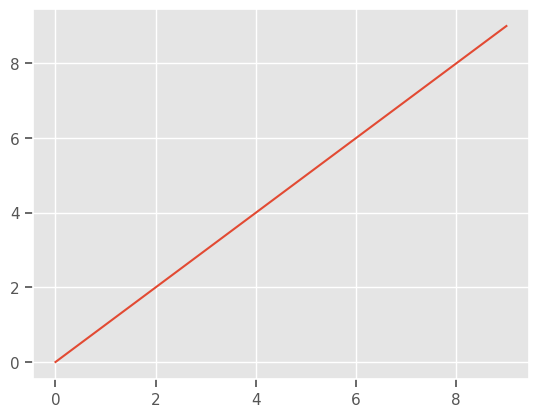

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot') #Stilo ggplot
sns.set_context ('notebook') #Da el contexto para presentar el gráfico (paper, notebbok, talk, poster) 
plt.plot(range(10));


<Axes: xlabel='year'>

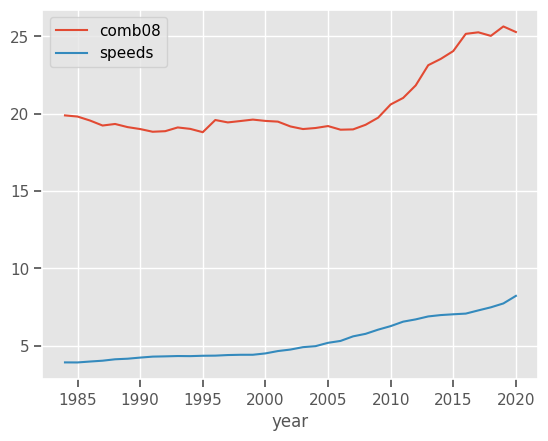

In [ ]:
(autos2
    .groupby('year')
    [['comb08','speeds']]
    .mean() 
    .plot()
)

MAS GRAFICOS Y AGREGATION:

Podemos hacer muchos mas gráficos hermosos...:

<Axes: xlabel='year'>

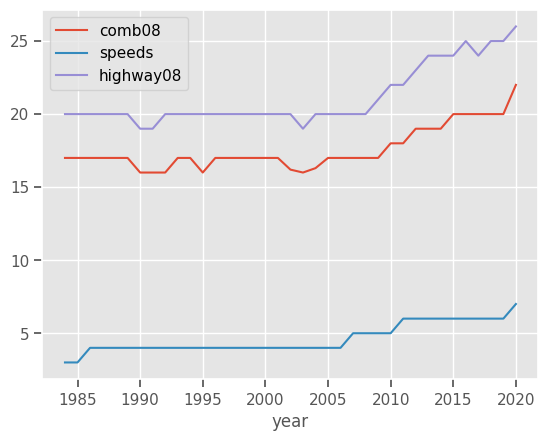

In [ ]:
(autos2
    .groupby('year')
    [['comb08','speeds', 'highway08']]
    #.mean()
    #.median()
    .quantile(.3)
    #.std()
    #.var()
    .plot()
)

In [ ]:
# MAS AGREGATION. Agregaremos  columna country
(autos2
    .assign(country=autos2.make.apply(country))
    .groupby(['year','country'])
    [['comb08','speeds']]
    .mean()
    )
# Notaremos que primero se agrupa por el year y luego por el country

comb08    speeds
year country                     
1984 Other    21.417330  3.969054
     US       17.797119  3.872749
1985 Other    21.373068  3.958057
     US       18.025157  3.886792
1986 Other    21.213622  4.069659
...                 ...       ...
2018 US       25.925267  7.238434
2019 Other    25.456922  7.817038
     US       26.250000  7.443662
2020 Other    25.174359  8.153846
     US       26.571429  9.214286

[74 rows x 2 columns]

También se pueden hacer multiples agregations

In [ ]:
#Se puede ir más profundo y aplicar multiples aggregations
def second_to_last(ser):
    return ser.iloc[-2]

(autos2
    .assign(country=autos2.make.apply(country))
    .groupby(['year','country'])
    [['comb08','speeds']]
    .agg(['min','mean', second_to_last])
    )
#El resultado es similar  a un Table pivot de excel

comb08                           speeds                         
                min       mean second_to_last    min      mean second_to_last
year country                                                                 
1984 Other        8  21.417330             14      3  3.969054              5
     US           9  17.797119             17      3  3.872749              4
1985 Other        8  21.373068             20      3  3.958057              4
     US          10  18.025157             15      3  3.886792              4
1986 Other        7  21.213622             11      3  4.069659              4
...             ...        ...            ...    ...       ...            ...
2018 US          14  25.925267            116      1  7.238434              1
2019 Other       11  25.456922             22      1  7.817038              8
     US          14  26.250000            104      1  7.443662              1
2020 Other       15  25.174359             20      1  8.153846             10
     US          22  26.571429             24      5  9.214286             10

[74 rows x 6 columns]

In [ ]:
(autos2
    .assign(country=autos2.make.apply(country))
    .groupby(['year','country'])
    [['comb08','speeds']]
    .mean()
    )

comb08    speeds
year country                     
1984 Other    21.417330  3.969054
     US       17.797119  3.872749
1985 Other    21.373068  3.958057
     US       18.025157  3.886792
1986 Other    21.213622  4.069659
...                 ...       ...
2018 US       25.925267  7.238434
2019 Other    25.456922  7.817038
     US       26.250000  7.443662
2020 Other    25.174359  8.153846
     US       26.571429  9.214286

[74 rows x 2 columns]

In [ ]:
(autos2
    .assign(country=autos2.make.apply(country))
    .groupby(['year','country'])
    [['comb08','speeds']]
    .mean()
    .unstack()
    )

comb08               speeds          
country      Other         US     Other        US
year                                             
1984     21.417330  17.797119  3.969054  3.872749
1985     21.373068  18.025157  3.958057  3.886792
1986     21.213622  17.645390  4.069659  3.886525
1987     20.710414  17.326007  4.142653  3.902930
1988     20.814642  17.372951  4.205607  4.028689
1989     20.662261  16.908898  4.264317  4.025424
1990     20.640747  16.577011  4.328149  4.105747
1991     20.174468  16.599532  4.341844  4.234192
1992     20.098731  16.735437  4.356841  4.252427
1993     20.309760  16.896373  4.371994  4.279793
1994     20.264423  16.829609  4.355769  4.293296
1995     20.091054  16.422287  4.380192  4.313783
1996     20.906615  16.961390  4.416342  4.262548
1997     20.509470  16.991453  4.452652  4.290598
1998     20.457295  17.408000  4.485765  4.272000
1999     20.386023  17.756972  4.507488  4.215139
2000     20.301370  17.757812  4.619863  4.253906
2001     20.289026  17.496212  4.761978  4.412879
2002     20.076923  16.979021  4.920174  4.367133
2003     19.953020  16.628763  5.154362  4.307692
2004     19.923833  16.805195  5.229730  4.308442
2005     19.892078  17.132203  5.362801  4.688136
2006     19.509025  17.285714  5.492178  4.776557
2007     19.452038  17.626712  5.864508  4.883562
2008     19.677985  17.937956  5.969332  5.120438
2009     20.186329  18.259928  6.189636  5.563177
2010     20.851598  19.600858  6.378995  5.866953
2011     21.635308  19.014870  6.714286  6.066914
2012     22.339751  20.111524  6.834655  6.286245
2013     23.471658  21.823293  7.033155  6.385542
2014     23.655870  23.012658  7.210526  6.046414
2015     23.935294  24.441065  7.211765  6.353612
2016     24.439716  27.701818  7.296859  6.301818
2017     24.910521  26.496377  7.474926  6.594203
2018     24.779868  25.925267  7.551270  7.238434
2019     25.456922  26.250000  7.817038  7.443662
2020     25.174359  26.571429  8.153846  9.214286

In [ ]:
#Volviendo al ejemplo inicial
(autos2
    .assign(country=autos2.make.apply(country))
    .groupby(['year','country'])
    [['comb08','speeds']]
    .mean()
    )

comb08    speeds
year country                     
1984 Other    21.417330  3.969054
     US       17.797119  3.872749
1985 Other    21.373068  3.958057
     US       18.025157  3.886792
1986 Other    21.213622  4.069659
...                 ...       ...
2018 US       25.925267  7.238434
2019 Other    25.456922  7.817038
     US       26.250000  7.443662
2020 Other    25.174359  8.153846
     US       26.571429  9.214286

[74 rows x 2 columns]

<Axes: xlabel='year'>

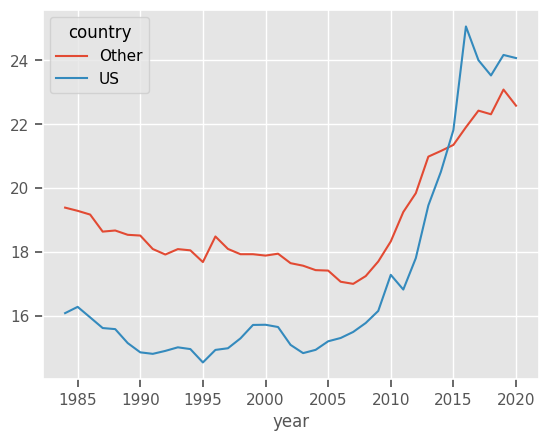

In [ ]:
#El cuadro de arriba lo puedo hacer más entendible para un gráfico.
(autos2
    .assign(country=autos2.make.apply(country))
    .groupby(['year','country'])
    [['city08','speeds']]
    .mean()
    .unstack()
    .city08
    .plot()
    )

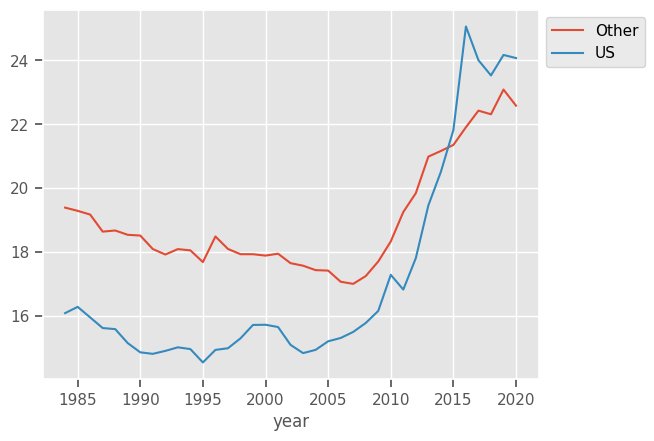

In [ ]:
(autos2
    .assign(country=autos2.make.apply(country))
    .groupby(['year','country'])
    [['city08','speeds']]
    .mean()
    .unstack()
    .city08
    .plot()
    .legend(bbox_to_anchor=(1,1))#Moviendo la posicion de la leyenda
    )

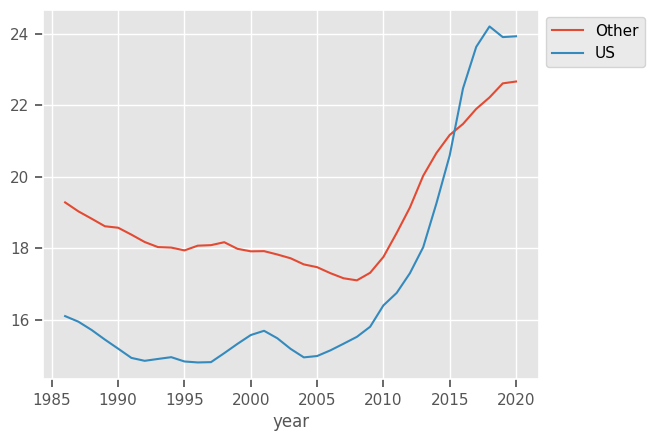

In [ ]:
(autos2
    .assign(country=autos2.make.apply(country))
    .groupby(['year','country'])
    [['city08','speeds']]
    .mean()
    .unstack()
    .city08
    .rolling(3)
    .mean()
    .plot()
    .legend(bbox_to_anchor=(1,1))#Moviendo la posicion de la leyenda
    )

<Axes: xlabel='year'>

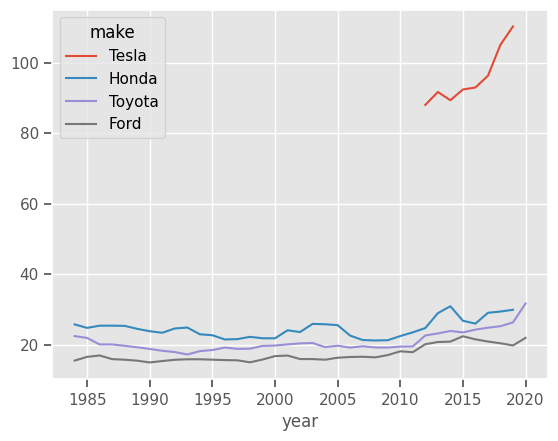

In [ ]:
# MAS EJEMPLOS DE LIMPIEZA CON MATPLOTLIB
makes=['Tesla','Honda','Toyota','Ford']
(autos
    .query('make.isin(@makes)')
    #.loc[autos.make.isin(makes)]
    .groupby(['year','make'])
    .city08
    .mean()
    .unstack()
    .loc[:,makes]
    .plot()
)

Haciendo un GRAFICO BIEN CHULO

findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not

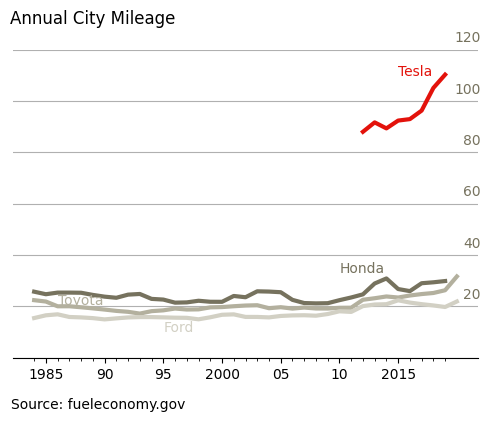

In [45]:
sns.reset_defaults()
makes = ['Tesla', 'Honda', 'Toyota', 'Ford']
colors = ['#e3120b', '#76725e', '#b3b09e', '#d2d0c4']
fig, ax = plt.subplots(figsize=(6,4), dpi=100)
ax = (autos
 #.query('make.isin(@makes)')
 .loc[autos.make.isin(makes)]
 .groupby(['year', 'make'])
 .city08
 .mean()
 .unstack()
 .loc[:, makes]
 .plot(color=colors, legend=False, linewidth=3, ax=ax)
)
plt.rcParams["font.family"] = "Roboto"
plt.grid(axis='y')
plt.suptitle('Annual City Mileage', ha='left', x=.12)
[ax.spines[side].set_visible(False) for side in ['top', 'left', 'right']]
ax.tick_params(left=False) # hide ticks
ax.set_xlabel('') # clear x label
ax.set_xticks(minor=True, ticks=range(1984,2020))
# set positions and labels for major ticks
ax.set_xticks(ticks=range(1985,2019,5))
ax.set_xticklabels(['1985', '90', '95', '2000', '05', '10', '2015'])
ax.set_yticks(ticks=range(0,121,20))
ax.set_yticklabels([]) # hide left hand side
for label in range(20,121,20): # my own vertically shifted y-labels
    ax.text(2022, label+3, f'{label}', color=colors[-3], ha='right')
for label, pos, color in zip(makes, [(2015, 110), # label makes
                              (2010, 33),
                              (1986, 20.5),
                              (1995, 10),
                             ], colors):
    ax.text(*pos, label, color=color, ha='left')
_ = ax.text(1982, -20, 'Source: fueleconomy.gov', ha='left')
fig
